In [ ]:
# Clone the detr github repo
!git clone https://github.com/facebookresearch/detr.git
import os
os.chdir('detr')
!git checkout 8a144f83a287f4d3fece4acdf073f387c5af387d

Cloning into 'detr'...
remote: Enumerating objects: 263, done.
remote: Total 263 (delta 0), reused 0 (delta 0), pack-reused 263
Receiving objects: 100% (263/263), 12.88 MiB | 20.93 MiB/s, done.
Resolving deltas: 100% (122/122), done.
Note: switching to '8a144f83a287f4d3fece4acdf073f387c5af387d'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 8a144f8 docs: add GH button in support of Ukraine (#490)


In [ ]:
# Import required libraries
import argparse
import random
from pathlib import Path

import numpy as np
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import PIL.Image

import util.misc as utils
from models import build_model

from main import get_args_parser

In [ ]:
# Setup the model arguement parser
parser = argparse.ArgumentParser(description="DETR Args Parser", parents=[get_args_parser()])
args = parser.parse_args(args=[])
args.resume = 'https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth'
args.device = 'cpu'

if args.output_dir:
  Path(args.output_dir).mkdir(parents=True, exist_ok=True)

args.distributed = False

print(args)

Namespace(lr=0.0001, lr_backbone=1e-05, batch_size=2, weight_decay=0.0001, epochs=300, lr_drop=200, clip_max_norm=0.1, frozen_weights=None, backbone='resnet50', dilation=False, position_embedding='sine', enc_layers=6, dec_layers=6, dim_feedforward=2048, hidden_dim=256, dropout=0.1, nheads=8, num_queries=100, pre_norm=False, masks=False, aux_loss=True, set_cost_class=1, set_cost_bbox=5, set_cost_giou=2, mask_loss_coef=1, dice_loss_coef=1, bbox_loss_coef=5, giou_loss_coef=2, eos_coef=0.1, dataset_file='coco', coco_path=None, coco_panoptic_path=None, remove_difficult=False, output_dir='', device='cpu', seed=42, resume='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth', start_epoch=0, eval=False, num_workers=2, world_size=1, dist_url='env://', distributed=False)


In [ ]:
model, criterion, postprocessors = build_model(args)

device = torch.device(args.device)
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 214MB/s]


DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, ou

In [ ]:
# Download and load pretrained model weights
output_dir = Path(args.output_dir)
if args.resume:
  if args.resume.startswith('https'):
    checkpoint = torch.hub.load_state_dict_from_url(
        args.resume, map_location='cpu', check_hash=True
    )
  else:
    checkpoint = torch.hub.load_state_dict_from_url(
        args.resume, map_location='cpu'
    )
  model.load_state_dict(checkpoint['model'], strict=True)

Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth
100%|██████████| 159M/159M [00:00<00:00, 172MB/s]


In [ ]:
# COCO Classes
CLASSES = [
   'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
   'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
   'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
   'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
   'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
   'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
   'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
   'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
   'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
   'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
   'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
   'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
   'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
   'toothbrush'
]

In [ ]:
# Colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# Standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# For output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

# Resize bounding boxes to be full size of the image
def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [ ]:
def detect(im, model, transform):
  img = transform(im).unsqueeze(0)
  assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600
  outputs = model(img)
  probas = outputs['pred_logits'].softmax(-1)[0,:,:-1]
  keep = probas.max(-1).values > 0.7
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
  return probas[keep], bboxes_scaled

In [ ]:
def plot_results(pil_img, class_probs, b_boxes, classes, is_ground_truth=False):
    plt.figure(figsize=(16,10))
    plt.axis('off')
    ax = plt.gca()
    ax.imshow(pil_img)

    for p, (xmin, ymin, xmax, ymax), c in zip(class_probs, b_boxes, COLORS * 100):
        cl = p if is_ground_truth else p.argmax()

        # If the class isn't present, skip this annotation
        if CLASSES[cl] not in classes:
            continue
        # Plot bounding box and label (Note difference in bounding box format, xmax vs xmax-xmin)
        xmax = xmax if is_ground_truth else xmax-xmin
        ymax = ymax if is_ground_truth else ymax-ymin
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax, ymax, fill=False, color=c, linewidth=3))

        text = f"{CLASSES[cl]}" if is_ground_truth else f"{CLASSES[cl]}: {p[cl]:0.2f}"
        ax.text(xmin,ymin, text, fontsize=15, bbox=dict(facecolor="yellow", alpha=0.5))

    # Show the plot
    plt.show()

In [ ]:
!wget http://images.cocodataset.org/zips/val2017.zip
!unzip val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip annotations_trainval2017.zip

Streaming output truncated to the last 5000 lines.
 extracting: val2017/000000577584.jpg  
 extracting: val2017/000000346905.jpg  
 extracting: val2017/000000433980.jpg  
 extracting: val2017/000000228144.jpg  
 extracting: val2017/000000041872.jpg  
 extracting: val2017/000000117492.jpg  
 extracting: val2017/000000368900.jpg  
 extracting: val2017/000000376900.jpg  
 extracting: val2017/000000352491.jpg  
 extracting: val2017/000000330790.jpg  
 extracting: val2017/000000384850.jpg  
 extracting: val2017/000000032735.jpg  
 extracting: val2017/000000197004.jpg  
 extracting: val2017/000000526751.jpg  
 extracting: val2017/000000041488.jpg  
 extracting: val2017/000000153632.jpg  
 extracting: val2017/000000501523.jpg  
 extracting: val2017/000000405691.jpg  
 extracting: val2017/000000040757.jpg  
 extracting: val2017/000000219485.jpg  
 extracting: val2017/000000428280.jpg  
 extracting: val2017/000000209222.jpg  
 extracting: val2017/000000353051.jpg  
 extracting: val2017/00000019

In [ ]:
import json
annFile = '/content/detr/annotations/instances_val2017.json'
with open(annFile, 'r') as json_file:
  anno_dict = json.load(json_file)

annos = anno_dict["annotations"]
images = anno_dict["images"]

In [ ]:
rand_index = np.random.randint(0,len(images))
image_id = images[rand_index]['id']
file_name = images[rand_index]['file_name']
annos_in_img = [(anno['category_id'], anno['bbox']) for anno in annos if anno['image_id'] == image_id]

Predicted: 


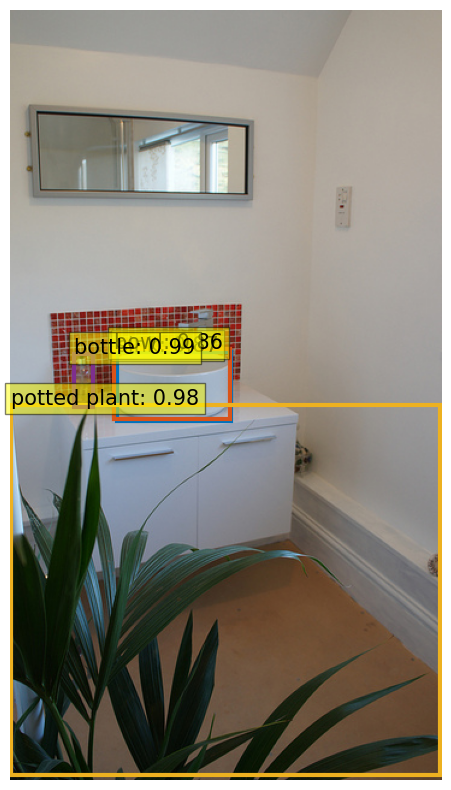

Ground Truth: 


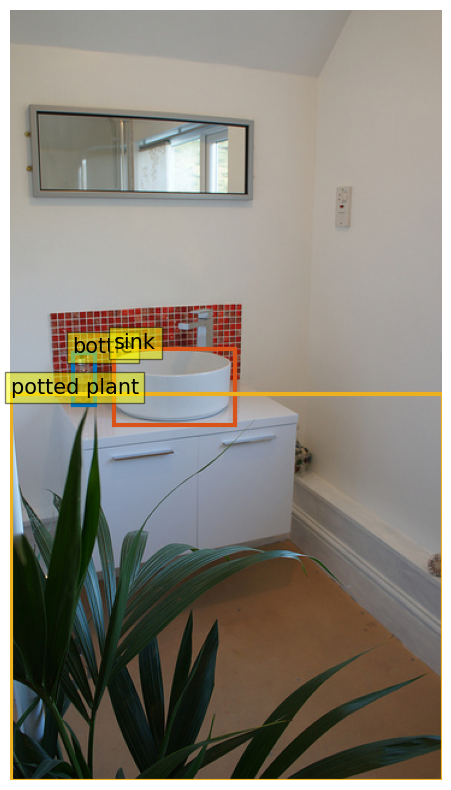

In [ ]:
the_image = PIL.Image.open(f'/content/detr/val2017/{file_name}')
scores, boxes = detect(the_image, model, transform)

print('Predicted: ')
plot_results(the_image, scores, boxes.tolist(), CLASSES)

print('Ground Truth: ')
plot_results(the_image, *zip(*annos_in_img), CLASSES, is_ground_truth=True)